<a href="https://colab.research.google.com/github/zixuantan/Databusters/blob/main/NUS_DSESC_DATABUSTERS_XX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1) Libraries Installation
##### The cell below is to help you keep track the libraries used and install them quickly.
##### Ensure the correct library names are used, and follow the syntax: **%pip install PACKAGE_NAME**.

In [ ]:
# %pip install pandas
# %pip install matplotlib
# %pip install dplyr
# %pip install ggplot2
# %pip install tidyr
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should follow the format %pip install PACKAGE_NAME

## 2) Main Section for Code
### **ALL code for machine learning and dataset analysis** should be entered below.
##### Ensure that your code is clear and readable.
##### Remember to include comments and markdown notes as necessary to explain and highlight important segments of your code.

OUTMS         HOAMS        RSAFSx       ACOGNOx       ANDENOx 
          112           112           132           132            36 
    OILPRICEx       COMPRMS        OPHMFG        ULCMFG  MORTGAGE30US 
          108           112           112           112            49 
   MORTG10YRx    CPF3MTB3Mx      REVOLSLx       DRIWCIL       USSTHPI 
           49           152            36            93            64 
    SPCS10RSA     SPCS20RSA TWEXAFEGSMTHx        EXUSEU    USEPUINDXM 
          112           164           188           160           104 
         CP3M      COMPAPFF     NASDAQCOM  CUSR0000SEHC 
          152           152            48            96

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



   Lag_Length      AIC      BIC
1           2 1205.386 1215.370
2           3 1207.162 1220.474
3           4 1209.156 1225.796
4           5 1210.950 1230.917
5           6 1212.916 1236.212
7           8 1213.215 1243.166
6           7 1213.591 1240.214
8           9 1215.071 1248.350
9          10 1217.071 1253.677
11         12 1218.210 1261.473
10         11 1218.849 1258.783
   Lag_Length      AIC      BIC
1           3 1137.341 1147.144
2           4 1139.338 1152.409
3           5 1141.276 1157.616
4           6 1143.178 1162.785
6           8 1143.838 1169.981
5           7 1143.841 1166.716
7           9 1145.518 1174.928
10         12 1147.296 1186.510
8          10 1147.497 1180.176
9          11 1149.219 1185.165
  Lag_Length      AIC      BIC
1          5 1066.485 1076.097
2          6 1068.135 1080.951
3          7 1069.559 1085.579
4          8 1069.896 1089.120
5          9 1070.641 1093.069
6         10 1072.551 1098.183
8         12 1074.134 1106.174
7         11 107

Importance of components:
                           PC1     PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     12.1301 4.52076 3.93005 2.82605 2.49354 2.12761 2.06014
Proportion of Variance  0.6628 0.09206 0.06957 0.03598 0.02801 0.02039 0.01912
Cumulative Proportion   0.6628 0.75485 0.82442 0.86040 0.88840 0.90879 0.92791
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     1.48550 1.34156 1.22581 1.18657 1.08249 1.04535 0.94551
Proportion of Variance 0.00994 0.00811 0.00677 0.00634 0.00528 0.00492 0.00403
Cumulative Proportion  0.93785 0.94596 0.95273 0.95907 0.96435 0.96927 0.97330
                          PC15   PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     0.88992 0.8157 0.74161 0.66440 0.62284 0.55151 0.54406
Proportion of Variance 0.00357 0.0030 0.00248 0.00199 0.00175 0.00137 0.00133
Cumulative Proportion  0.97686 0.9799 0.98234 0.98433 0.98608 0.98745 0.98878
                          PC22

Number of components selected to explain 90% variance: 6 
    Annualized_Real_GDP_Growth           PC1          PC2         PC3
36                 3.086138255 -18.903646869   5.71980525 -6.35566039
37                 1.568019022 -18.981167006   6.22112041 -5.82895775
38                 6.209278408 -18.837542826   6.19027273 -5.49256077
39                 1.211579026 -18.725843910   6.78215043 -5.22704366
40                 2.631136814 -18.730584717   7.13192771 -5.01010935
41                -1.957618735 -18.557641168   7.29874340 -4.87793102
42                -0.596010670 -18.349441812   7.68237868 -4.62494108
43                 0.566472357 -18.611137280   8.23572079 -4.18075608
44                 3.668991104 -18.525570989   7.70180214 -4.32830940
45                -4.309423465 -18.457252600   6.84314726 -4.30761021
46                10.719666074 -18.331947061   6.43364837 -4.72259193
47                 2.157438105 -18.196551565   4.79358721 -5.20051180
48                 3.276332647 -

[1] "PAYEMS"           "USPRIV"           "TNWBSHNOx"       
  [4] "USGOVT"           "GS5"              "TABSHNOx"        
  [7] "TARESAx"          "MANEMP"           "HOUST"           
 [10] "PERMIT"           "DSERRG3Q086SBEA"  "SRVPRD"          
 [13] "TB3MS"            "DMANEMP"          "GDPC1"           
 [16] "USGOOD"           "CES9093000001"    "IPDBS"           
 [19] "S.P.PE.ratio"     "CUSR0000SA0L5"    "CPIULFSL"        
 [22] "LNS13023621"      "DHCERG3Q086SBEA"  "GS1"             
 [25] "TABSNNBx"         "BAA"              "GS10"            
 [28] "IPCONGD"          "TB6MS"            "PCECTPI"         
 [31] "CIVPART"          "PCECC96"          "HOUSTMW"         
 [34] "FEDFUNDS"         "GDPCTPI"          "AAA"             
 [37] "CPIAUCSL"         "CUSR0000SAS"      "LNS13023557"     
 [40] "DFSARG3Q086SBEA"  "USCONS"           "IPMAT"           
 [43] "UEMP15T26"        "INDPRO"           "DNDGRG3Q086SBEA" 
 [46] "NDMANEMP"         "LNS14000012"      "HOUSTW"          
 [49] "PCEPILFE"         "CONSUMERx"        "CPIMEDSL"        
 [52] "DRCARG3Q086SBEA"  "PERMITS"          "CPILFESL"        
 [55] "CUSR0000SA0L2"    "IPB51222S"        "AWHNONAG"        
 [58] "PERMITNE"         "TFAABSHNOx"       "HOUSTNE"         
 [61] "IPNMAT"           "GFDEBTNx"         "AMDMNOx"         
 [64] "UMCSENTx"         "OUTBS"            "CUSR0000SAC"     
 [67] "Y033RC1Q027SBEAx" "IPMANSICS"        "BUSINVx"         
 [70] "FPIx"             "REALLNx"          "EXJPUSx"         
 [73] "DGDSRG3Q086SBEA"  "USEHS"            "DHLCRG3Q086SBEA" 
 [76] "INVEST"           "DOTSRG3Q086SBEA"  "DHUTRG3Q086SBEA" 
 [79] "LNS12032194"      "USLAH"            "HOUSTS"          
 [82] "PPICMM"           "PERMITMW"         "OUTNFB"          
 [85] "PCDGx"            "WPSFD49207"       "DONGRG3Q086SBEA" 
 [88] "USTPU"            "PERMITW"          "GCEC1"           
 [91] "EXCAUSx"          "NWPIx"            "USPBS"           
 [94] "DODGRG3Q086SBEA"  "WPU0561"          "TLBSNNCBx"       
 [97] "AWOTMAN"          "AAAFFM"           "CNCFx"           
[100] "GFDEGDQ188S"      "LNS14000026"      "S.P.500"         
[103] "AHETPIx"          "CE16OV"           "USTRADE"         
[106] "ISRATIOx"         "CES9092000001"    "EXPGSC1"         
[109] "PRFIx"            "PCNDx"            "USWTRADE"        
[112] "B021RE1Q156NBEA"  "GPDICTPI"         "CES0600000008"   
[115] "TLBSNNBx"         "DPIC96"           "UNRATE"          
[118] "TLBSNNBBDIx"      "IPFUELS"          "HOANBS"          
[121] "CES2000000008x"   "UEMPLT5"          "IPNCONGD"        
[124] "FGRECPTx"         "NONREVSLx"        "S.P.div.yield"   
[127] "AMDMUOx"          "WPSID61"          "SLCEx"           
[130] "HOUST5F"          "OPHPBS"           "INVCQRMTSPL"     
[133] "B020RE1Q156NBEA"  "HNOREMQ027Sx"     "WPSFD49502"      
[136] "DFXARG3Q086SBEA"  "TLBSHNOx"         "PPIACO"          
[139] "IPFINAL"          "WPSID62"          "DIFSRG3Q086SBEA" 
[142] "CMRMTSPLx"        "HWIURATIOx"       "WPSFD4111"       
[145] "IPB51220SQ"       "CPITRNSL"         "TTAABSNNCBx"     
[148] "IPDMAT"           "TNWMVBSNNCBx"     "USSERV"          
[151] "CUSR0000SAD"      "PCESVx"           "HOABS"           
[154] "BUSLOANSx"        "UEMP27OV"         "TNWBSNNBx"       
[157] "COMPRNFB"         "PNFIx"            "CONSPIx"         
[160] "TOTALSLx"         "UNRATESTx"        "CES3000000008x"  
[163] "ULCBS"            "PPIIDC"           "ULCNFB"          
[166] "DFDHRG3Q086SBEA"  "CPIAPPSL"         "OPHNFB"          
[169] "DDURRG3Q086SBEA"  "DTCTHFNM"         "TNWBSNNBBDIx"    
[172] "M2REAL"           "DTRSRG3Q086SBEA"  "IMPGSC1"         
[175] "DTCOLNVHFNM"      "TCU"              "DGOERG3Q086SBEA" 
[178] "DMOTRG3Q086SBEA"  "USFIRE"           "UEMP5TO14"       
[181] "IPB51110SQ"       "RCPHBS"           "GPDIC1"          
[184] "IPBUSEQ"          "EXSZUSx"          "UNRATELTx"       
[187] "IPDCONGD"         "UNLPNBS"          "LNS14000025"     
[190] "DREQRG3Q086SBEA"

[1] "Combined dataset with previous and newly identified top predictors:"
      sasdate growth_tmr_Q4 GDP_an_growth CES0600000007 VIXCLSx CES9091000001
36   6/1/1967   3.086138255   0.245330628       40.0333 16.6095      2849.000
37   9/1/1967   1.568019022   3.766515019       40.2667 11.8708      2869.000
38  12/1/1967   6.209278408   3.004104191       40.3333 14.2165      2873.667
39   3/1/1968   1.211579026   8.075025353       40.2000 16.4624      2865.000
40   6/1/1968   2.631136814   6.626302827       40.3667 15.9763      2876.667
41   9/1/1968  -1.957618735   3.086138255       40.4000 14.1053      2886.667
42  12/1/1968  -0.596010670   1.568019022       40.3333 12.0105      2862.000
43   3/1/1969   0.566472357   6.209278408       40.3333 14.7335      2900.667
44   6/1/1969   3.668991104   1.211579026       40.4667 14.5498      2900.000
45   9/1/1969  -4.309423465   2.631136814       40.3000 18.7238      2901.333
46  12/1/1969  10.719666074  -1.957618735       40.2333 15.8104     

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-17.003   1.070   2.548   2.616   4.341  18.020 

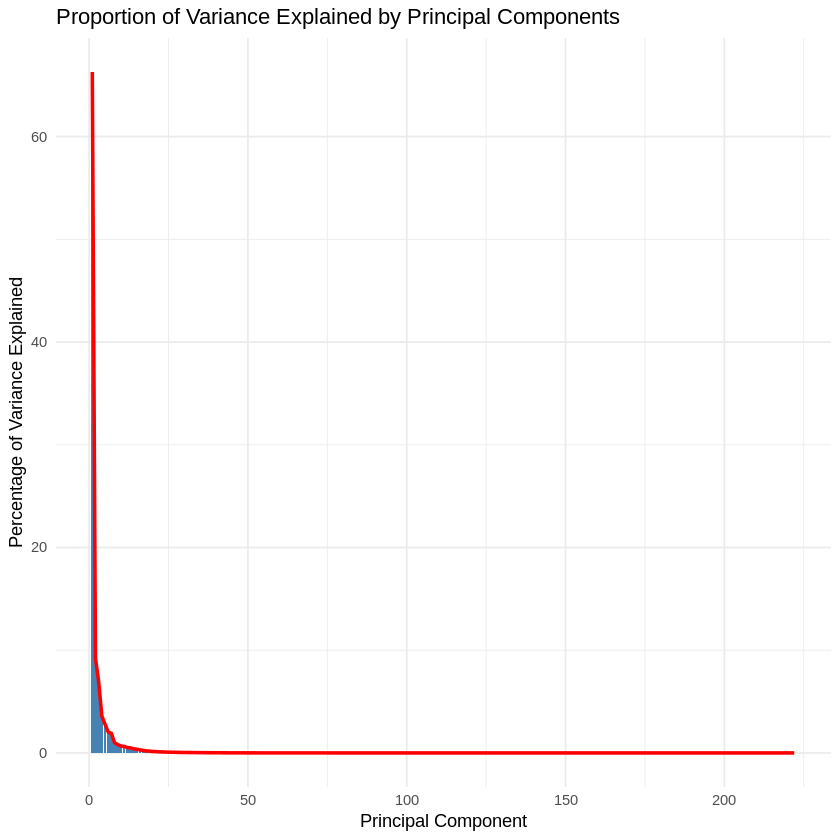

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in `[.data.frame`(data_cleaned_trimmed, non_lagged_vars, drop = FALSE):
“'drop' argument will be ignored”


     211 
3.182215 
Root Mean Squared Error (RMSE): 3.072214 


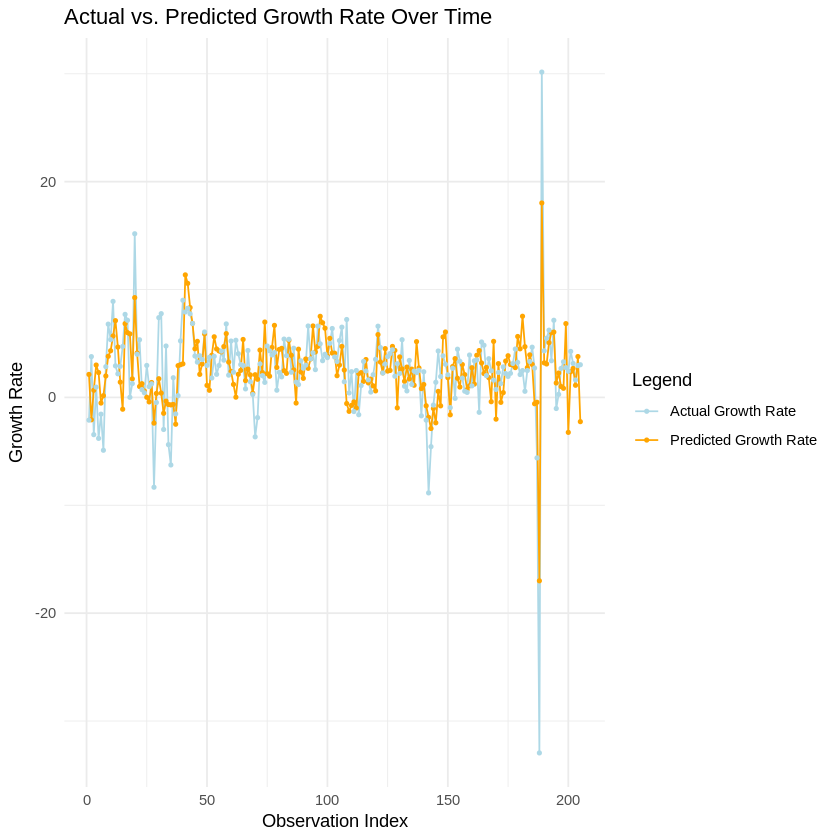

In [2]:
# Set the URL of the CSV file
url <- 'https://raw.githubusercontent.com/zixuantan/Databusters/refs/heads/main/Quarterly%20Data.csv'

# Read the CSV file
quarterly <- read.csv(url)
Q_data = quarterly[3:nrow(quarterly),]


#################
# data cleaning #
#################
missing_values <- colSums(is.na(Q_data))
missing_values[missing_values > 32]
# from the summary, i discovered some variables with close to (or even more than) half of the obs being NA
# i decided to remove those with more than 32NAs, so that's 24 predictors --> good balance between number
# of predictors and observations removed

# moreover, looking through many of these 24 predictors, they seem to be highly correlated with some
# other predictors, so it is justifiable to remove them (find 2 e.g., add in abit of economic explanation)

#removing 24 predictors
# Step 1: Find columns with more than 32 NAs
columns_to_remove <- names(missing_values[missing_values > 32])  # Columns with more than 32 NAs

# Step 2: Remove those columns from the dataset
data_cleaned <- Q_data[, !(names(Q_data) %in% columns_to_remove)]

#Remove the 32 rows with NA values
# Find the last row's index
last_row_index <- nrow(data_cleaned)

#Remove rows with NA values, except for the last row
data_cleaned <- data_cleaned[complete.cases(data_cleaned) | rownames(data_cleaned) == rownames(data_cleaned)[last_row_index], ]

# tranform gdp growth
data_cleaned$GDP_an_growth <- c(0, diff(log(data_cleaned$GDPC1)*400))
data_copy <- data_cleaned

####################################
# AR Lag for each forecast horizon #
####################################
#install.packages("dplyr")
library(dplyr)
max_lag <- 12
# Horizon 1: Q1 2025
for (lag in 2:max_lag) {
  data_copy[[paste0("Lag_", lag, "_Annualized_GDP_Growth")]] <-
    dplyr::lag(data_copy$GDP_an_growth, lag)
}

# Drop rows with NA values from lagging
data_copy <- na.omit(data_copy)

# Initialize results storage
aic_bic_results <- data.frame(Lag_Length = integer(), AIC = numeric(), BIC = numeric())

# Ensure consistent number of rows in each iteration
n_obs <- nrow(data_copy) - max_lag

# Fit models with different lag lengths
for (lag in 2:max_lag) {
  # Select lagged variables as predictors
  predictors <- paste0("Lag_", 2:lag, "_Annualized_GDP_Growth")
  X_lagged <- data_copy[1:n_obs, predictors, drop = FALSE]  # Fixed number of rows
  y <- data_copy$GDP_an_growth[1:n_obs]  # Ensure y has same rows as X_lagged

  # Fit the model using OLS
  model <- lm(y ~ ., data = X_lagged)

  # Store AIC and BIC for each lag length
  aic_bic_results <- rbind(aic_bic_results,
                           data.frame(Lag_Length = lag,
                                      AIC = AIC(model),
                                      BIC = BIC(model)))
}

# Sort by AIC and print results
aic_bic_results <- aic_bic_results[order(aic_bic_results$AIC), ]
print(aic_bic_results)


# Horizon 2: Q2 2025

for (lag in 3:max_lag) {
  data_copy[[paste0("Lag_", lag, "_Annualized_GDP_Growth")]] <-
    dplyr::lag(data_copy$GDP_an_growth, lag)
}

# Drop rows with NA values from lagging
data_copy <- na.omit(data_copy)

# Initialize results storage
aic_bic_results <- data.frame(Lag_Length = integer(), AIC = numeric(), BIC = numeric())

# Ensure consistent number of rows in each iteration
n_obs <- nrow(data_copy) - max_lag

# Fit models with different lag lengths
for (lag in 3:max_lag) {
  # Select lagged variables as predictors
  predictors <- paste0("Lag_", 3:lag, "_Annualized_GDP_Growth")
  X_lagged <- data_copy[1:n_obs, predictors, drop = FALSE]  # Fixed number of rows
  y <- data_copy$GDP_an_growth[1:n_obs]  # Ensure y has same rows as X_lagged

  # Fit the model using OLS
  model <- lm(y ~ ., data = X_lagged)

  # Store AIC and BIC for each lag length
  aic_bic_results <- rbind(aic_bic_results,
                           data.frame(Lag_Length = lag,
                                      AIC = AIC(model),
                                      BIC = BIC(model)))
}

# Sort by AIC and print results
aic_bic_results <- aic_bic_results[order(aic_bic_results$AIC), ]
print(aic_bic_results)


# Horizon 3: Q2 2025
max_lag <- 12

for (lag in 5:max_lag) {
  data_copy[[paste0("Lag_", lag, "_Annualized_GDP_Growth")]] <-
    dplyr::lag(data_copy$GDP_an_growth, lag)
}

# Drop rows with NA values from lagging
data_copy <- na.omit(data_copy)

# Initialize results storage
aic_bic_results <- data.frame(Lag_Length = integer(), AIC = numeric(), BIC = numeric())

# Ensure consistent number of rows in each iteration
n_obs <- nrow(data_copy) - max_lag

# Fit models with different lag lengths
for (lag in 5:max_lag) {
  # Select lagged variables as predictors
  predictors <- paste0("Lag_", 5:lag, "_Annualized_GDP_Growth")
  X_lagged <- data_copy[1:n_obs, predictors, drop = FALSE]  # Fixed number of rows
  y <- data_copy$GDP_an_growth[1:n_obs]  # Ensure y has same rows as X_lagged

  # Fit the model using OLS
  model <- lm(y ~ ., data = X_lagged)

  # Store AIC and BIC for each lag length
  aic_bic_results <- rbind(aic_bic_results,
                           data.frame(Lag_Length = lag,
                                      AIC = AIC(model),
                                      BIC = BIC(model)))
}

# Sort by AIC and print results
aic_bic_results <- aic_bic_results[order(aic_bic_results$AIC), ]
print(aic_bic_results)



###############################################
# Optimal ADL lag and its respective datasets #
###############################################

# Y(t) = aY(t-2) + b [Q1 2025]
growth_tmr_Q1 = data_cleaned$GDP_an_growth[4:231]
tsdata_Q1 = cbind(growth_tmr_Q1, data_cleaned[2:229,])


# Y(t) = aY(t-3) + b [Q2 2025)]
growth_tmr_Q2 = data_cleaned$GDP_an_growth[5:231]
tsdata_Q2 = cbind(growth_tmr_Q2, data_cleaned[2:228,])


# Y(t) = aY(t-5) + b [Q2 2025)]
growth_tmr_Q4 = data_cleaned$GDP_an_growth[7:231]
tsdata_Q4 = cbind(growth_tmr_Q4, data_cleaned[2:226,])



# Selecting best predictors
# Remove predictors which are highly correlated to each other
library(dplyr)
library(ggplot2)

# Step 1: Select only predictor columns (exclude target and non-numeric columns)
predictor_data <- tsdata_Q4 %>%
  select(-growth_tmr_Q4, -sasdate)

# Step 2: Perform PCA on predictors (standardizing the data is important for PCA)
pca_result <- prcomp(predictor_data, scale. = TRUE)

# Step 3: View summary of PCA results
summary(pca_result)

# Step 4: Plot the proportion of variance explained by each principal component
explained_variance <- data.frame(PC = 1:length(pca_result$sdev),
                                 Variance_Explained = (pca_result$sdev^2 / sum(pca_result$sdev^2)) * 100)

ggplot(explained_variance, aes(x = PC, y = Variance_Explained)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  geom_line(color = "red", group = 1, size = 1) +
  labs(title = "Proportion of Variance Explained by Principal Components",
       x = "Principal Component",
       y = "Percentage of Variance Explained") +
  theme_minimal()

# Step 5: Select the number of components that explain most of the variance (e.g., 90% cutoff)
cumulative_variance <- cumsum(explained_variance$Variance_Explained)
selected_components <- which(cumulative_variance >= 90)[1]

cat("Number of components selected to explain 90% variance:", selected_components, "\n")

# Step 6: Create a new dataset with selected components
pca_predictors <- as.data.frame(pca_result$x[, 1:selected_components])
final_pca_data <- cbind(tsdata_Q4$growth_tmr_Q4, pca_predictors)

# Step 7: Rename the target variable for clarity
colnames(final_pca_data)[1] <- "Annualized_Real_GDP_Growth"

# Step 8: View the final dataset with selected components
print(final_pca_data)

#PC6 Selected as it explains 90% variance

#Extract loadings for PC6 and all predictors
loadings_PC6 <- as.data.frame(pca_result$rotation) %>%
  select(PC6) %>%
  mutate(Predictor = rownames(pca_result$rotation))

#Sort the loadings by magnitude (absolute value)
loadings_PC6 <- loadings_PC6 %>%
  arrange(desc(abs(PC6)))

#View all predictors contributing to PC6 (sorted)
print("All predictors contributing to PC6:")
print(loadings_PC6)

#Filter and view the most important predictors (absolute loading > 0.1)
important_predictors_PC6 <- loadings_PC6 %>%
  filter(abs(PC6) > 0.1)  # Set threshold to 0.1 (adjust as needed)

print("Top predictors with |loading| > 0.1:")
print(important_predictors_PC6)

# Define the list of top predictors contributing to PC6
top_predictors <- c(
  "GDP_an_growth", "CES0600000007", "VIXCLSx", "CES9091000001", "A014RE1Q156NBEA",
  "AWHMAN", "T5YFFM", "GS1TB3Mx", "BAA10YM", "TNWMVBSNNCBBDIx", "EXUSUKx",
  "LNS13023569", "NIKKEI225", "NONBORRES", "HWIx", "TOTRESNS", "CLAIMSx",
  "LIABPIx", "UEMPMEAN", "WPU0531", "GS10TB3Mx", "CUMFNS", "USINFO",
  "A823RL1Q225SBEA", "DCLORG3Q086SBEA", "TLBSNNCBBDIx", "TB6M3Mx", "M1REAL",
  "TB3SMFFM", "BOGMBASEREALx", "USMINE", "LNS13023705"
)

#Checking if any other important predictor is missing
#install.packages("tidyr")
library(tidyr)
#Extract PCA loadings
loadings <- as.data.frame(pca_result$rotation)

#Identify predictors with |loading| > 0.1 across all PCs
significant_loadings <- loadings %>%
  mutate(Predictor = rownames(loadings)) %>%
  pivot_longer(cols = starts_with("PC"), names_to = "PC", values_to = "Loading") %>%
  filter(abs(Loading) > 0.1) %>%
  arrange(desc(abs(Loading)))

#Check for missing important predictors
all_top_predictors <- significant_loadings %>%
  filter(!(Predictor %in% top_predictors))

print("Potential missing important predictors:")
unique(all_top_predictors$Predictor)

# Adding important predictors based on domain knowledge
# Combine the previous top predictors and new important predictors
combined_predictors <- unique(c(
  top_predictors,  # Previous top predictors from PC6
  "PAYEMS", "FEDFUNDS", "CPIAUCSL", "PCECC96", "PERMIT",
  "IMPGSC1", "EXPGSC1", "M2REAL", "REALLNx", "BUSINVx", "UMCSENTx"
))

# Step 2: Create a dataset with the combined predictors, date, and GDP growth
new_tsdata_Q4 <- tsdata_Q4 %>%
  select(sasdate, growth_tmr_Q4, all_of(combined_predictors))

# Step 3: View the first few rows of the combined dataset
print("Combined dataset with previous and newly identified top predictors:")
print(new_tsdata_Q4)

# 4) Using AIC/BIC and testing each of the 20 predictors individually at different lags to find the best
max_lags <- 20
data_aic <- tsdata_Q4
y_var <- "growth_tmr_Q4"
base_predictor <- "GDP_an_growth"

if (!(base_predictor %in% colnames(data_aic))) {
  stop("Error: Base predictor not found in dataset.")
}

for (predictor in combined_predictors) {
  for (lag in 1:max_lags) {
    data_aic[[paste0(predictor, "_Lag_", lag)]] <- dplyr::lag(data_aic[[predictor]], lag)
  }
}

data_aic <- na.omit(data_aic)
y <- data_aic[[y_var]]

X_base <- data_aic[, base_predictor, drop = FALSE]
best_model <- lm(y ~ ., data = X_base)
best_aic <- AIC(best_model)
current_predictors <- c(base_predictor)

cat("Base Model AIC:", best_aic, "\n\n")

for (predictor in combined_predictors) {
  best_lag_aic <- best_aic
  selected_lag <- NULL

  for (lag in 1:max_lags) {
    lagged_col <- paste0(predictor, "_Lag_", lag)
    if (!(lagged_col %in% colnames(data_aic))) next

    X_new <- data_aic[, c(current_predictors, lagged_col), drop = FALSE]
    model <- lm(y ~ ., data = X_new)

    cat("Testing", predictor, "(Lag", lag, ") | AIC:", AIC(model), ", BIC:", BIC(model), "\n")

    if (AIC(model) < best_lag_aic) {
      best_lag_aic <- AIC(model)
      selected_lag <- lagged_col
      best_model <- model
    }
  }

  if (!is.null(selected_lag)) {
    cat("Selected", predictor, "(Lag", selected_lag, ") for the model.\n\n")
    current_predictors <- c(current_predictors, selected_lag)
    best_aic <- best_lag_aic
  }
}

cat("\nFinal Model Summary:\n")
print(summary(best_model))

# Create a continuous time index (1, 2, 3, ...) for plotting
library(ggplot2)
library(dplyr)


# in sample prediction
X_new$UMCSENTx_Lag_6 <- data_aic$UMCSENTx_Lag_6
predlm = predict.lm(best_model, newdata = X_new)
data_aic$predlm <- predlm
summary(predlm)

data_aic <- na.omit(data_aic)

# Create a continuous time index (1, 2, 3, ...) for plotting
library(ggplot2)
library(dplyr)


# Create a continuous time index (1, 2, 3, ...) for plotting
data_aic <- data_aic %>%
  mutate(time_index = row_number())  # Generates a continuous sequence

# Check if there are multiple observations before plotting
if (nrow(data_aic) > 1) {
  ggplot(data_aic, aes(x = time_index)) +
    geom_line(aes(y = growth_tmr_Q4, color = "Actual Growth Rate"), size = 0.5) +  # Thinner solid line
    geom_line(aes(y = predlm, color = "Predicted Growth Rate"), size = 0.5) +  # Thinner solid line
    geom_point(aes(y = predlm, color = "Predicted Growth Rate"), size = 0.8) +  # Dots for predictions
    geom_point(aes(y = growth_tmr_Q4, color = "Actual Growth Rate"), size = 0.8) +  # Dots for actual values (fix)
    labs(title = "Actual vs. Predicted Growth Rate Over Time",
         x = "Observation Index",
         y = "Growth Rate",
         color = "Legend") +
    theme_minimal() +
    scale_color_manual(values = c("Actual Growth Rate" = "lightblue", "Predicted Growth Rate" = "orange"))
} else {
  print("Not enough data points to create a line plot.")
}
#install.packages("zoo")
library(dplyr)
library(zoo)

# Extract selected variable names
variables_selected <- names(X_new)

# Exclude GDP_an_growth from lag processing
variables_selected <- setdiff(variables_selected, "GDP_an_growth")

# Function to get lagged values dynamically for all valid observations
get_lagged_values <- function(data, column_names, max_lag) {
  lagged_values <- list()

  for (col_name in column_names) {
    match_lag <- regmatches(col_name, regexec("_Lag_(\\d+)", col_name))

    if (length(match_lag[[1]]) > 1) {
      lag <- as.numeric(match_lag[[1]][2])  # Extract numeric lag value
      base_col_name <- gsub("_Lag_\\d+", "", col_name)  # Remove "_Lag_X" to get base variable name

      if (!base_col_name %in% names(data)) {
        warning(paste("Column", base_col_name, "not found in data_cleaned"))
        next
      }

      # Shift values properly to align with data
      lagged_values[[col_name]] <- c(rep(NA, lag), data[[base_col_name]][1:(nrow(data) - lag)])
    }
  }

  return(as.data.frame(lagged_values))
}

# --- Main Forecasting Code ---

# 1. Identify lagged and non-lagged variable names
lag_columns <- variables_selected[grep("_Lag_", variables_selected)]
non_lagged_vars <- setdiff(variables_selected, lag_columns)

# 2. Determine the maximum lag
max_lag <- max(as.numeric(gsub(".*_Lag_(\\d+)", "\\1", lag_columns)), na.rm = TRUE)

# 3. Extract lagged values ensuring correct row count
lagged_values_df <- get_lagged_values(data_cleaned, lag_columns, max_lag)

# 4. Trim data_cleaned to match valid rows
valid_start <- max_lag + 1  # Exclude first `max_lag` rows to align data
data_cleaned_trimmed <- data_cleaned[valid_start:nrow(data_cleaned), , drop = FALSE]

# 5. Align row counts before merging
rows_to_keep <- min(nrow(lagged_values_df), nrow(data_cleaned_trimmed))
lagged_values_df <- lagged_values_df[1:rows_to_keep, , drop = FALSE]
data_cleaned_trimmed <- data_cleaned_trimmed[1:rows_to_keep, , drop = FALSE]

# 6. Construct X_future ensuring structure matches the model's expectations
X_future <- bind_cols(lagged_values_df, data_cleaned_trimmed[non_lagged_vars, drop = FALSE])

# 7. Ensure column types match the training data
X_future <- X_future %>%
  mutate(across(where(is.character), as.numeric)) %>%  # Convert character to numeric
  mutate(across(where(is.factor), as.character))      # Convert factors to characters

# 8. Ensure GDP_an_growth is numeric
if (!is.numeric(X_future$GDP_an_growth)) {
  X_future$GDP_an_growth <- as.numeric(X_future$GDP_an_growth)
}

# 9. Check for missing variables and fill them with NA
missing_vars <- setdiff(names(best_model$model), names(X_future))
if (length(missing_vars) > 0) {
  X_future[missing_vars] <- NA  # Add missing columns with NA values
}

# 10. Ensure column order matches model training data
X_future <- X_future[, names(best_model$model), drop = FALSE]

# 11. Handle missing values (mean imputation + filling remaining NAs)
X_future <- X_future %>%
  mutate(across(everything(), ~ ifelse(is.na(.), mean(., na.rm = TRUE), .)))  # Replace NA with column mean

# 12. Fill any remaining NAs with 0 (if mean imputation failed)
X_future[is.na(X_future)] <- 0

# 13. Final checks before predictions
if (any(is.na(X_future))) {
  stop("Error: X_future still contains NA values. Check data preprocessing.")
}

if (!is.numeric(X_future$GDP_an_growth)) {
  stop("Error: GDP_an_growth is not numeric.")
}

# 14. Make predictions for the last available row
forecast_values <- predict(best_model, newdata = X_future[nrow(X_future), , drop = FALSE])

# 15. Print the forecasted values
print(forecast_values)

# Actual values of GDP growth (from your dependent variable)
actual <- data_aic$growth_tmr_Q4

# Predicted values using the final model
predicted <- predict(best_model, newdata = data_aic)

# Calculate RMSE
rmse <- sqrt(mean((actual - predicted)^2))

# Print the RMSE
cat("Root Mean Squared Error (RMSE):", rmse, "\n")

#### Remember to rename your file name to **NUS_DSESC_DATABUSTERS_XX.ipynb** and ensure that it can run successfully. Good luck and have fun!